## 2. Fasea: Algoritmoak diseinatzen

#### Julen Etxaniz eta Aitor Zubillaga

Community Detection proiektuaren 1. fasea entregatu duzue, eta feedback-a jaso ere. Klasean hainbat algoritmo ikusi ditugu, batzuk soluzio bakarrean oinarritutakoak, beste batzuk aldiz, populazio bat erabiltzen dutenak. Horiez gain, hibridatzeko teknikak ere ikusi ditugu. Bigarrengo fase honetan, bi algoritmo diseinatu beharko dituzue, bata soluzio bakarrean oinarritutakoa, eta bestea poblazionala. Ez hori bakarrik, bi algoritmoetako batek operadore probabilistikoak erabili beharko ditu, Estimation of Distribution Algorithms (EDAk) edo Ant Colony Optimization (ACO)-ek egiten duten bezala. Algoritmoen helburua, komunitate kopuru jakin bat emanik, modularity maximizatzen duen komunitate banaketa (soluzioa) bilatzen saiatzea da.

Errepasatu gaitegian zehar ikusi ditugun algoritmo guztiak, eta horiek kontuak izanik, libre zarete nahi dituzuen diseinuak sortzeko, baita ere hibridoak! Adi! Egiten duzuen aukeraketa argudiatu egin beharko duzue.


#### Entregablea

Bigarrengo fasea ebaluatu ahal izateko, notebook honetan bertan algoritmoen diseinua eta implementazioa proposatu beharko duzue. Gogoratu algoritmo bat azaltzeko modurik errezena diagrama bat egitea dela. Adi! Atal bakoitzean hartutako erabakiak eta garatutako metodoak egoki argudiatu beharko dituzue. Ez argudiatzeak edo lana garaiz ez entregatzeak penalizazioa jasoko dute ebaluagarria den proiektuaren zati honetan. eGelan zehazten dira notebook-a igotzeko <b>egun eta orduak</b>.

Momentuz, ez daukazue algoritmoen exekuzio eta konparaketak egin behar. Hirugarren fasean, esperimentazioaren inguruko baldintzak emango dizkizuet, eta, horrez gain, txostenaren idazketa burutu beharko duzue.

```python
## Hemendik aurrera, intuizioa da nagusi...

Nire aukeraketa, UMDA bat swap-LS batekin eta metodo eraikitzaile batekin.

Eta bestea, ILS bat, metodo eraikitzaile estokastiko batekin eta,
```



## Grafoa sortu

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/2. Lauhilekoa/BH/Proiektua - Community Detection

/content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/2. Lauhilekoa/BH/Proiektua - Community Detection


In [ ]:
%cd /content/drive/MyDrive/Proiektua - Community Detection

/content/drive/.shortcut-targets-by-id/1YBawHqMJJ5PaYxHZNg5RnM4UIRU8tnJ7/Proiektua - Community Detection


In [4]:
# SQL
import sqlite3

# Pandas
import pandas as pd

# Graph
import community
import networkx as nx

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Combinations
import itertools

def sortu_grafoa():
    # Get data
    connect = sqlite3.connect('data/database.sqlite')
    query = """
    SELECT pa.paper_id, pa.author_id, a.name
    FROM paper_authors AS pa JOIN papers AS p ON pa.paper_id = p.id
    JOIN authors as a ON pa.author_id = a.id
    WHERE p.Year BETWEEN '2014' AND '2015'
    """
    df = pd.read_sql(query, connect)

    # Have a look at data
    df.head(10)

    # Initialize graph
    G = nx.Graph()

    # Transform
    # Autorearen IDa erabili beharrean erabili izena.
    for p, a in df.groupby('paper_id')['name']: 
        for u, v in itertools.combinations(a, 2):
            if G.has_edge(u, v):
                G[u][v]['weight'] +=1
            else:
                G.add_edge(u, v, weight=1)
                
    # Print graph size
    print('Autore kopurua grafoan:', G.number_of_nodes())
    print('Elkarlan kopurua grafoan:', G.number_of_edges())
    
    return G

def bistaratu_grafoa(G):
    plt.figure(figsize=(13, 9))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size = 20, node_color='0.75', label=True)
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=1)
    plt.show()

    plt.axis('off')
    plt.show()

In [5]:
G = sortu_grafoa()

Autore kopurua grafoan: 1843
Elkarlan kopurua grafoan: 3215


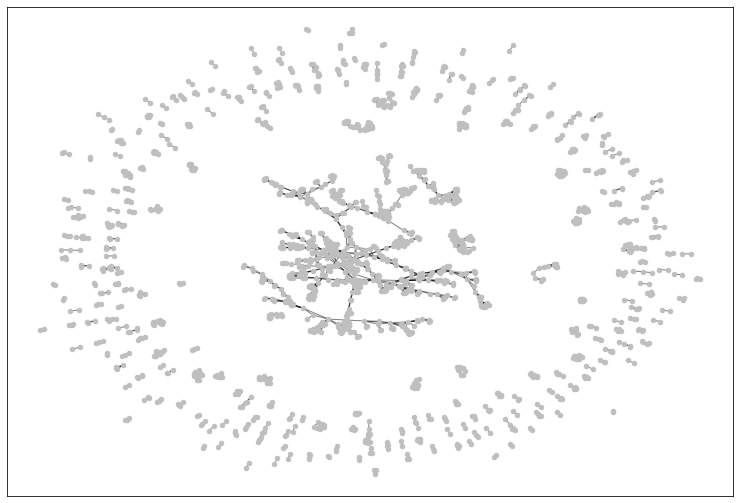

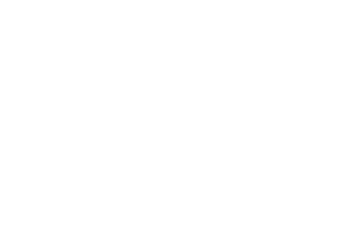

In [6]:
bistaratu_grafoa(G)

## Helburu-funtzioa

In [7]:
import numpy as np
# 50 komunitate ausaz
soluzioa_1 = np.random.randint(50, size=1843)
# 10 komunitate ausaz
soluzioa_2 = np.random.randint(10, size=1843)
print(list(soluzioa_1))
print(list(soluzioa_2))

[32, 37, 31, 45, 21, 35, 16, 43, 42, 22, 2, 0, 34, 10, 46, 7, 7, 40, 47, 29, 2, 23, 31, 3, 4, 0, 46, 26, 11, 22, 45, 45, 1, 21, 43, 23, 47, 12, 32, 37, 10, 30, 40, 49, 47, 48, 19, 34, 21, 49, 35, 10, 47, 23, 37, 44, 49, 31, 32, 18, 33, 23, 19, 1, 30, 12, 28, 9, 19, 29, 24, 35, 48, 22, 37, 31, 5, 38, 38, 28, 23, 37, 30, 24, 21, 15, 5, 26, 38, 49, 5, 7, 12, 15, 5, 8, 49, 31, 34, 42, 47, 1, 41, 25, 32, 15, 17, 9, 19, 0, 12, 18, 23, 49, 37, 2, 3, 9, 4, 41, 28, 33, 15, 9, 33, 12, 8, 27, 11, 29, 10, 4, 33, 45, 48, 29, 47, 43, 29, 41, 37, 0, 47, 5, 15, 35, 46, 46, 41, 27, 0, 19, 38, 22, 21, 40, 42, 8, 11, 45, 23, 20, 15, 48, 15, 34, 47, 24, 20, 38, 36, 9, 18, 22, 37, 25, 1, 17, 37, 23, 32, 49, 16, 34, 8, 26, 18, 12, 39, 7, 47, 33, 30, 49, 27, 34, 25, 45, 38, 39, 18, 15, 28, 44, 16, 26, 10, 43, 46, 3, 0, 48, 39, 46, 32, 25, 36, 33, 0, 19, 19, 14, 11, 20, 45, 7, 38, 44, 22, 4, 28, 46, 3, 34, 49, 16, 48, 33, 36, 3, 15, 24, 40, 24, 37, 16, 22, 42, 10, 13, 44, 43, 1, 9, 16, 32, 39, 32, 31, 1, 30, 

In [8]:
import community
from collections import defaultdict

### Helburu-funtzioa
def modularity(G, partition, weight='weight'):
    weights = defaultdict(float)
    degrees = defaultdict(float)
    sum = G.size(weight=weight)
    modularity = 0

    for node in G:
        community = partition[node]
        degrees[community] += G.degree(node, weight=weight)
        for neighbour, data in G[node].items():
            if partition[neighbour] == community:
                if neighbour == node: # 4 nodes have self edges
                    weights[community] += data[weight] * 2
                else:
                    weights[community] += data[weight]

    for community in set(partition.values()):
        modularity += (weights[community] / (2 * sum)) - (degrees[community] / (2 * sum)) ** 2
    return modularity

## Gure inplementazioa
partition1 = dict(zip(G.nodes, soluzioa_1))
partition2 = dict(zip(G.nodes, soluzioa_2))

print("Gure helburu-funtzioa:")
print("1. soluzioaren modularitatea:", modularity(G, partition1))
print("2. soluzioaren modularitatea:", modularity(G, partition2))
print("Community moduluko modularity:")
print("1. soluzioaren modularitatea:", community.modularity(partition1, G))
print("2. soluzioaren modularitatea:", community.modularity(partition2, G))

Gure helburu-funtzioa:
1. soluzioaren modularitatea: 0.0018760209623991625
2. soluzioaren modularitatea: -0.007773411973386083
Community moduluko modularity:
1. soluzioaren modularitatea: 0.0018760209623991625
2. soluzioaren modularitatea: -0.007773411973386083


In [9]:
best_partition = community.best_partition(G)
print("Komunitate kopurua:", max(best_partition.values())+1)
print("Soluzio onenaren modularitatea:", community.modularity(best_partition, G))

Komunitate kopurua: 292
Soluzio onenaren modularitatea: 0.9722773464278018


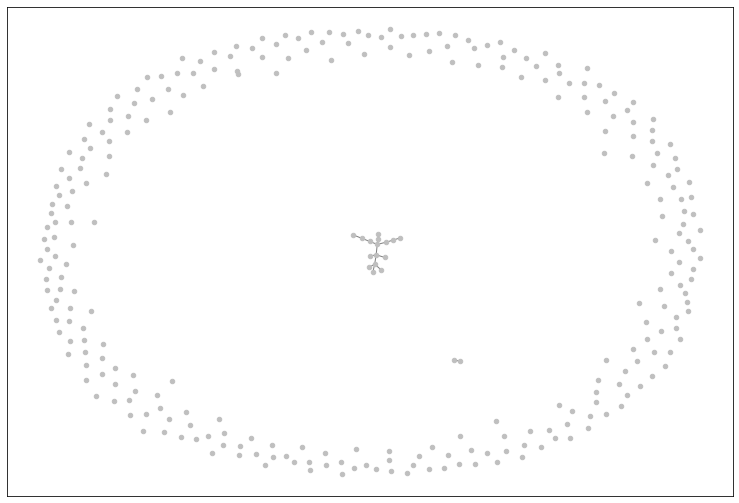

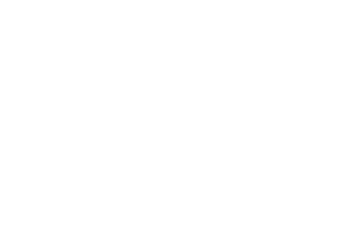

In [10]:
G2 = community.induced_graph(best_partition, G)
bistaratu_grafoa(G2)

## Random Search

In [ ]:
def random_search(G, num_solutions, count):
    size = G.number_of_nodes()
    best_solution = list(np.random.randint(count, size=size))
    best_partition = dict(zip(G.nodes, best_solution))
    best_fitness = modularity(G, best_partition)
    for i in range(num_solutions-1):
        solution = list(np.random.randint(count, size=size))
        partition = dict(zip(G.nodes, best_solution))
        fitness = modularity(G, best_partition)
        if fitness > best_fitness:
            best_fitness = fitness
            best_solution = solution
    return (best_fitness, best_solution, num_solutions)

## Libraries

Community library https://python-louvain.readthedocs.io/en/latest/

https://github.com/taynaud/python-louvain/tree/master/community

CDLib library https://cdlib.readthedocs.io/en/latest/

## Constructive

Fast unfolding of communities in large networks https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008/meta

From Louvain to Leiden: guaranteeing well-connected communities https://www.nature.com/articles/s41598-019-41695-z

## 1. Local Search

community detection local search https://scholar.google.es/scholar?hl=es&as_sdt=0%2C5&q=community+detection+local+search&oq=com

An evolutionary method for community detection using a novel local search strategy https://www.sciencedirect.com/science/article/pii/S0378437119301402

An iterated local search algorithm for community detection in complex networks https://www.worldscientific.com/doi/abs/10.1142/S0217979220500137

A novel iterated greedy algorithm for detecting communities in complex network https://link.springer.com/content/pdf/10.1007/s13278-020-00641-y.pdf

### Swap

In [ ]:
def swap(solution, i, j):
    solution[i], solution[j] = solution[j], solution[i]
    return solution

def swap_neighbours(solution):
    neighbours = []
    size = len(solution)
    for i in range(size):
        for j in range(i+1, size):
            neighbours.append(swap(solution[:], i, j))
    return neighbours

def best_first_swap(G, best_solution, best_fitness, evals, max_evals):
    improve = False
    size = len(best_solution)
    for i in range(size):
        for j in range(i+1, size):
            solution = swap(best_solution[:], i, j)
            partition = dict(zip(G.nodes, solution))
            fitness = modularity(G, partition)
            evals += 1
            if fitness > best_fitness:
                improve = True
                return (fitness, solution, evals, improve)
            if evals == max_evals:
                return (best_fitness, best_solution, evals, improve)
    return (best_fitness, best_solution, evals, improve)

def local_search_swap(G, max_evals, count):
    size = G.number_of_nodes()
    best_solution = list(np.random.randint(count, size=size))
    #best_partition = dict(zip(G.nodes, best_solution))
    best_partition = community.best_partition(G)
    best_fitness = modularity(G, best_partition)
    improve = True
    evals = 1
    while evals < max_evals and improve:
        best_fitness, best_solution, evals, improve = best_first_swap(G, best_solution, best_fitness, evals, max_evals)
        
    return (best_fitness, best_solution, evals)

### Insert

In [ ]:
def insert(solution, i, j):
    solution.insert(j, solution.pop(i))
    return solution

def insert_neighbours(solution):
    neighbours = []
    size = len(solution)
    for i in range(size):
        for j in list(range(0, i-1)) + list(range(i+1, size)):
            neighbours.append(insert(solution[:], i, j))
    return neighbours

def best_first_insert(G, best_solution, best_fitness, evals, max_evals):
    improve = False
    size = len(best_solution)
    for i in range(size):
        for j in list(range(0, i-1)) + list(range(i+1, size)):
            solution = insert(best_solution[:], i, j)
            partition = dict(zip(G.nodes, solution))
            fitness = modularity(G, partition)
            evals += 1
            if fitness > best_fitness:
                improve = True
                return (fitness, solution, evals, improve)
            if evals == max_evals:
                return (best_fitness, best_solution, evals, improve)
    return (best_fitness, best_solution, evals, improve)

def local_search_insert(G, max_evals, count):
    size = G.number_of_nodes()
    best_solution = list(np.random.randint(count, size=size))
    best_partition = dict(zip(G.nodes, best_solution))
    best_fitness = modularity(G, best_partition)
    improve = True
    evals = 1
    while evals < max_evals and improve:
        best_fitness, best_solution, evals, improve = best_first_insert(G, best_solution, best_fitness, evals, max_evals)
        
    return (best_fitness, best_solution, evals)

### Hamming

In [ ]:
def hamming(solution, i, cj):
    solution[i] = cj
    return solution

def hamming_neighbours(solution, count):
    neighbours = []
    size = len(solution)
    for i in range(size):
        for cj in range(count):
            neighbours.append(hamming(solution[:], i, cj))
    return neighbours

def best_first_hamming(G, best_solution, best_fitness, evals, max_evals, count):
    improve = False
    size = len(best_solution)
    for i in range(size):
        for j in range(count):
            solution = hamming(best_solution[:], i, j)
            partition = dict(zip(G.nodes, solution))
            fitness = modularity(G, partition)
            evals += 1
            if fitness > best_fitness:
                improve = True
                return (fitness, solution, evals, improve)
            if evals == max_evals:
                return (best_fitness, best_solution, evals, improve)
    return (best_fitness, best_solution, evals, improve)

def local_search_hamming(G, max_evals, count):
    size = G.number_of_nodes()
    best_solution = list(np.random.randint(count, size=size))
    best_partition = dict(zip(G.nodes, best_solution))
    best_fitness = modularity(G, best_partition)
    improve = True
    evals = 1
    while evals < max_evals and improve:
        best_fitness, best_solution, evals, improve = best_first_hamming(G, best_solution, best_fitness, evals, max_evals, count)
        
    return (best_fitness, best_solution, evals)

### Merge

In [ ]:
def merge(solution, ci, cj):
    # solution = np.where(solution == cj, ci)
    size = len(solution)
    for i in range(size):
        if solution[j] == cj:
            solution[j] = ci
    return solution

def merge_neighbours(solution, count):
    neighbours = []
    for ci in range(count):
        for cj in range(count):
            neighbours.append(merge(solution[:], ci, cj))
    return neighbours

### Simulated Annealing

In [ ]:
import random
import math

def initial_temperature(best_fitness):
    return 0.025 * best_fitness

def update_temperature(temp):
    return 0.9 * temp
    
def simmulated_annealing(best_solution, best_fitness, solution, fitness, temp):
    if fitness > best_fitness:
        best_solution = solution
        best_fitness = fitness
    else:
        p = random.uniform(0, 1)
        if p <= math.exp((fitness - best_fitness) / temp):
            best_solution = solution
            best_fitness = fitness
    temp = update_temperature(temp)
    return best_solution, best_fitness, temp

## Local Search vs Random Search

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import time as tm

# Egin exekuzioak budget desberdinetarako: 10, 100, 1000, 10000...
def run_search(function, count, budget=5, repetitions=1):
    list_budget = []
    list_fit = []
    list_time = []
    for exp in range(1, budget):
        budget=10**exp
        avg_fit = 0
        avg_time = 0
        for rep in tqdm(range(repetitions), position=0, leave=True):
            start = tm.time()
            (fitness, sol, evals) = function(G, budget, count)
            end = tm.time()
            avg_time += end - start
            avg_fit += fitness
        avg_fit = avg_fit/repetitions
        avg_time = avg_time/repetitions
        print()
        print("Budget:", budget, " Average fitness:", avg_fit, " Average time:", avg_time)
        list_budget.append(budget)
        list_fit.append(avg_fit)
        list_time.append(avg_time)
    return list_budget, list_fit, list_time

In [ ]:
list_budget, list_fit_ls_swap, list_time_ls_swap = run_search(local_search_swap, 50)

In [ ]:
list_budget, list_fit_ls_swap, list_time_ls_swap = run_search(local_search_swap, 50, budget=6)

In [ ]:
list_budget, list_fit_ls_swap, list_time_ls_swap = run_search(local_search_swap, 250)

In [ ]:
list_budget, list_fit_ls_swap, list_time_ls_swap = run_search(local_search_swap, 10)

In [ ]:
list_budget, list_fit_ls_swap, list_time_ls_swap = run_search(local_search_swap, 50)

In [ ]:
list_budget, list_fit_ls_ins, list_time_ls_ins = run_search(local_search_insert, 50)

In [ ]:
list_budget, list_fit_ls_ham, list_time_ls_ham = run_search(local_search_hamming, 50)

In [ ]:
list_budget, list_fit_rs, list_time_rs = run_search(random_search, 50)

In [ ]:
# Datuak gordetzeko egitura
datuak = pd.DataFrame({"n":list_budget,"Local Swap":list_fit_ls_swap,"Local Insert":list_fit_ls_ins,"Local Hamming":list_fit_ls_ham,"Random Search":list_fit_rs}) 
print(datuak)
print()

#Irudikatu emaitzak plot batean.
ax = plt.gca()
datuak.plot(kind='line',x='n',y='Local Swap',ax=ax)
datuak.plot(kind='line',x='n',y='Local Insert',ax=ax)
datuak.plot(kind='line',x='n',y='Local Hamming',ax=ax)
datuak.plot(kind='line',x='n',y='Random Search', color='red', ax=ax,title='Local Search vs. Random Search')
plt.show()

## 2. EDA

community detection eda https://scholar.google.es/scholar?hl=es&as_sdt=0%2C5&q=community+detection+eda&btnG=

An EDA-based Community Detection in Complex
Networks http://webpages.iust.ac.ir/mozayani/Papers-pdf/ieee79189c24-5f04-20150417114429.pdf

The Improved Estimation of Distribution Algorithms for Community Detection https://ieeexplore.ieee.org/abstract/document/8711535

https://github.com/DEAP/deap/tree/master/examples/eda

http://deap.gel.ulaval.ca/doc/default/examples/eda.html

In [278]:
count = 10
num_individuals = 10
size = G.number_of_nodes()

In [166]:
def initial_population():
    population = np.zeros((num_individuals, size), dtype=int)
    for i in range(num_individuals):
        solution = np.random.randint(count, size=size)
        population[i] = solution
    return population
population = initial_population()
print(population)

[[9 9 1 ... 6 3 9]
 [0 5 8 ... 4 6 6]
 [5 7 2 ... 0 2 3]
 ...
 [2 1 0 ... 5 0 6]
 [4 2 1 ... 6 7 5]
 [1 9 4 ... 1 8 5]]


In [167]:
def get_distribution(population):
    distribution = np.zeros((count, size), dtype=float)
    num_individuals = len(population)
    for individual in population:
        for i, com in enumerate(individual):
            distribution[com, i] += 1 / num_individuals
    return distribution

distribution = get_distribution(population)
print(distribution)

[[0.2 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.3 ... 0.1 0.1 0. ]
 [0.1 0.2 0.1 ... 0.1 0.1 0. ]
 ...
 [0.  0.2 0.  ... 0.1 0.2 0.1]
 [0.  0.  0.1 ... 0.  0.2 0.1]
 [0.2 0.2 0.1 ... 0.  0.  0.2]]


In [235]:
def cummulative_distribution(population):
    distribution = np.zeros((count, size), dtype=float)
    num_individuals = len(population)
    for individual in population:
        for i, com in enumerate(individual):
            for j in range(com, count):
                distribution[j, i] += 1 / num_individuals
    return distribution
    
distribution = cummulative_distribution(population)
print(distribution)

[[0.2 0.1 0.1 ... 0.1 0.1 0.1]
 [0.3 0.2 0.4 ... 0.2 0.2 0.1]
 [0.4 0.4 0.5 ... 0.3 0.3 0.1]
 ...
 [0.8 0.8 0.8 ... 1.  0.8 0.7]
 [0.8 0.8 0.9 ... 1.  1.  0.8]
 [1.  1.  1.  ... 1.  1.  1. ]]


In [223]:
def solution_modularity(solution):
    partition = dict(zip(G.nodes, solution))
    return modularity(G, partition)

def select_best(population):
    size = int(len(population) / 2)
    population = sorted(population, key=solution_modularity, reverse=True)
    population = population[:size]
    return population

def tournament_selection(population, tournaments = 5):
    size = int(len(population) / 2)
    winners = []
    for i in range(tournaments):
        solutions = random.choices(population, k=size)
        solutions = sorted(solutions, key=solution_modularity, reverse=True)
        winners.append(solutions[0])
    return winners

selected = select_best(population)
print(selected)
selected = tournament_selection(population)
print(selected)

[array([4, 0, 4, ..., 5, 7, 8]), array([4, 2, 1, ..., 6, 7, 5]), array([9, 5, 3, ..., 2, 8, 7]), array([1, 9, 4, ..., 1, 8, 5]), array([9, 9, 1, ..., 6, 3, 9])]
[array([1, 9, 4, ..., 1, 8, 5]), array([9, 9, 1, ..., 6, 3, 9]), array([9, 5, 3, ..., 2, 8, 7]), array([9, 5, 3, ..., 2, 8, 7]), array([4, 0, 4, ..., 5, 7, 8])]


In [262]:
def generate_solution(distribution):
    size = distribution.shape[1]
    solution = np.zeros(size, dtype=int)
    for i in range(size):
        r = random.uniform(0, 1)
        for j in range(count-1):
            if distribution[j][i] <= r and distribution[j+1][i] >= r:
                solution[i] = j+1
                break
    return solution

generated_solution = generate_solution(distribution)
print(generated_solution[:20])
print(solution_modularity(generated_solution))

[9 5 1 0 7 5 5 0 1 9 6 0 1 1 2 7 9 8 1 6]
-0.00041173572679446737


In [268]:
def generate_population(distribution):
    count = distribution.shape[0]
    size = distribution.shape[1]
    population = np.zeros((num_individuals, size), dtype=int)
    for i in range(size):
        for j in range(count-1):
            randoms = np.random.uniform(size=num_individuals)
            for k, r in enumerate(randoms):
                if distribution[j][i] <= r and distribution[j+1][i] > r:
                    population[k][i] = j+1
    return population

generated_population = generate_population(distribution)
print(generated_population[0][:50])
print(solution_modularity(generated_population[0]))

[9 9 4 6 0 0 2 0 0 1 6 5 0 0 0 9 0 6 2 0 9 9 9 8 0 8 8 6 0 4 7 8 9 6 4 9 0
 7 7 4 9 8 0 2 8 1 0 0 7 0]
0.00131517609834059


In [274]:
from tqdm import tqdm
def UMDA(G, max_evals, count):
    population = initial_population()
    evals = 0
    for i in tqdm(range(max_evals)):
        best = select_best(population)
        distribution = cummulative_distribution(best)
        population = generate_population(distribution)
        evals += 1
    sorted_population = sorted(population, key=solution_modularity, reverse=True)
    best_solution = sorted_population[0]
    best_fitness = solution_modularity(best_solution)
    return best_fitness, best_solution, evals

In [256]:
UMDA(G, 1000, count)

100%|██████████| 1000/1000 [07:01<00:00,  2.37it/s]


(0.04214431443467978, array([0, 8, 2, ..., 0, 8, 0]), 1000)

In [280]:
best_fitness, best_solution, evals = UMDA(G, 1, count)
print(best_fitness)
print(best_solution[:20])

100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


0.032012820525393754
[8 4 0 0 0 0 0 8 0 8 1 0 7 9 7 0 0 9 9 8]


## ACO

community detection aco https://scholar.google.es/scholar?hl=es&as_sdt=0%2C5&q=community+detection+aco&btnG=

An adaptive population control framework for ACO-based community detection https://www.sciencedirect.com/science/article/pii/S0960077920302861